## Setup

In [3]:
import torch

torch.cuda.is_available()

True

In [4]:
!ros2 topic info /camera_ids/image_color

Type: sensor_msgs/msg/Image
Publisher count: 1
Subscription count: 1


In [ ]:
# Training is performed on (3, 518, 518) images
# Evaluation in paper is performed on (3, 518, <some_multiple_of_14>) or (3, <some_multiple_of_14>, 518) with 518 for the smaller dimension and while keeping the original aspect ratio
# Paper states that inference works on other image scales as well (basically as long as dims are multiples of 14?)
shape_original = (1, 3, 720, 1280)
min_size_resized = 400
base = 14
name_model = "depth_anything_v2_metric_hypersim_vits"


import ros2_monocular_depth.transforms as transforms

shape_input = transforms.resize_shape_to_multiple_of_base(shape_original, min_size_resized=min_size_resized, base=base)
print(shape_input)

(1, 3, 406, 714)


## Export to ONNX

In [ ]:
import ros2_monocular_depth.scripts.export_model as export_model

export_model.export_model(name_model, shape_original=shape_original, min_size_resized=min_size_resized, base=base)

## Build engine

In [ ]:
import ros2_monocular_depth.scripts.build_engine as build_engine

build_engine.build_engine(name_model, limit_memory_workspace=1 << 32)

## Run node

In [6]:
import torch


class ModelCamera:
    """Base class for camera models."""

    def __init__(self, fx, fy, cx, cy, model_distortion, params_distortion, shape_image):
        self.cx = cx
        self.cy = cy
        self.fx = fx
        self.fy = fy
        self.model_distortion = model_distortion
        self.params_distortion = params_distortion
        self.shape_image = shape_image

    @classmethod
    def from_camera_info_message(cls, message):
        """Create an instance from a camera info message."""
        try:
            binning_x = message.binning_x if message.binning_x != 0 else 1
            binning_y = message.binning_y if message.binning_y != 0 else 1
        except AttributeError:
            binning_x = 1
            binning_y = 1

        try:
            offset_x = message.roi.offset_x
            offset_y = message.roi.offset_y
            # Do not know channel dimension from camera info message but keep it for pytorch-like style
            shape_image = (-1, message.roi.height, message.roi.width)
        except AttributeError:
            offset_x = 0
            offset_y = 0
            shape_image = (-1, message.height, message.width)

        fx = message.k[0] / binning_x
        fy = message.k[4] / binning_y
        cx = (message.k[2] - offset_x) / binning_x
        cy = (message.k[5] - offset_y) / binning_y

        model_distortion = message.distortion_model
        params_distortion = cls.create_dict_params_distortion(message.d)

        instance = cls(fx, fy, cx, cy, model_distortion, params_distortion, shape_image)
        return instance

    @classmethod
    def create_dict_params_distortion(cls, list_params_distortion):
        try:
            params_distortion = dict(zip(cls.keys_params_distortion, list_params_distortion))
        except AttributeError:
            params_distortion = dict(enumerate(list_params_distortion))

        return params_distortion

    def project_points_onto_image(self, coords_xyz):
        """Project 3D points onto 2D image.
        Shape of coords_xyz: (B, 3, N)
        Coordinate frame of points: [right, down, front]
        Coordinate frame of image: [right, down]"""
        raise NotImplementedError()

    def project_image_onto_points(self, coords_uv):
        """Project 2D image onto 3D unit sphere.
        Shape of coords_uv: (B, 2, N)
        Coordinate frame of points: [right, down, front]
        Coordinate frame of image: [right, down]"""
        raise NotImplementedError()


class ModelRationalPolynomial(ModelCamera):
    # Note: Distortion is ignored for now since they do not have a noticeable impact for the gemini.

    keys_params_distortion = ["k1", "k2", "p1", "p2", "k3", "k4", "k5", "k6"]

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # self.k1 = self.params_distortion["k1"]
        # self.k2 = self.params_distortion["k2"]
        # self.k3 = self.params_distortion["k3"]
        # self.k4 = self.params_distortion["k4"]
        # self.k5 = self.params_distortion["k5"]
        # self.k6 = self.params_distortion["k6"]
        # self.p1 = self.params_distortion["p1"]
        # self.p2 = self.params_distortion["p2"]

    def project_points_onto_image(self, coords_xyz):
        """Project 3D points onto 2D image.
        Shape of coords_xyz: (B, 3, N)
        Coordinate frame of points: [right, down, front]
        Coordinate frame of image: [right, down]"""
        coords_xyz = coords_xyz.to(self.device)

        x, y, z = coords_xyz[:, 0, :], coords_xyz[:, 1, :], coords_xyz[:, 2, :]

        u = self.fx * x / z + self.cx
        v = self.fy * y / z + self.cy

        coords_uv = torch.stack((u, v), axis=1)

        mask_valid = torch.ones_like(u, dtype=bool)

        return coords_uv, mask_valid

    def project_image_onto_points(self, coords_uv):
        """Project 2D image onto 3D unit sphere.
        Shape of coords_uv: (B, 2, N)
        Coordinate frame of points: [right, down, front]
        Coordinate frame of image: [right, down]"""
        coords_uv = coords_uv.to(self.device)

        u, v = coords_uv[:, 0, :], coords_uv[:, 1, :]

        mx = (u - self.cx) / self.fx
        my = (v - self.cy) / self.fy
        mz = torch.ones_like(mx)

        factor = 1.0 / torch.sqrt(mx**2 + my**2 + 1.0)
        coords_xyz = factor[:, None, :] * torch.stack((mx, my, mz), axis=1)

        mask_valid = torch.ones_like(mx, dtype=bool)

        return coords_xyz, mask_valid

In [ ]:
import IPython.display as display
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorrt as trt
import torch
from torch2trt import TRTModule
import torchvision.transforms.v2 as tv_transforms

from cv_bridge import CvBridge
from message_filters import ApproximateTimeSynchronizer, Subscriber as SubscriberFilter
from rclpy.callback_groups import MutuallyExclusiveCallbackGroup
from rclpy.node import Node
import rclpy.qos as qos
from sensor_msgs.msg import Image

import ros2_monocular_depth.config as config


class NodeDepthAnything(Node):
    def __init__(
        self,
        topic_color="/gemini2/color/image_raw",
        topic_depth="/gemini2/depth/image_raw",
        shape_original=shape_original,
        min_size_resized=min_size_resized,
        base=base,
        name_model=name_model,
        max_depth=20,
    ):
        super().__init__(node_name="depth_anything")

        self.base = base
        self.bridge_cv = None
        self.device = None
        self.max_depth = max_depth
        self.min_size_resized = min_size_resized
        self.name_model = name_model
        self.profile_qos = None
        self.shape_original = shape_original
        self.subscriber_color = None
        self.subscriber_depth = None
        self.topic_color = topic_color
        self.topic_depth = topic_depth

        self._init()

    @torch.inference_mode()
    def _init(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bridge_cv = CvBridge()
        self.profile_qos = qos.qos_profile_sensor_data

        self._init_model()
        self.transform = tv_transforms.Compose(
            [
                tv_transforms.PILToTensor(),
                transforms.ResizeToMultipleOfBase(min_size_resized=self.min_size_resized, base=self.base, mode_interpolation=transforms.MODES_INTERPOLATION.BICUBIC, use_antialiasing=False),
                tv_transforms.ToDtype(dtype=torch.float32, scale=True),
                tv_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        self.stream = torch.cuda.Stream()
        self.model_camera = ModelRationalPolynomial(
            690.5482788085938,
            690.9581909179688,
            646.66259765625,
            361.0751953125,
            model_distortion="rational_polynomial",
            params_distortion={},
            shape_image=(-1, 720, 1280),
        )

        self._init_subscribers()

    def _init_model(self):
        path_engine = Path(config._PATH_DIR_ENGINES) / f"{self.name_model}.engine"
        logger = trt.Logger(trt.Logger.INFO)
        runtime = trt.Runtime(logger)
        with open(path_engine, "rb") as file_engine:
            engine_serialized = file_engine.read()
        engine = runtime.deserialize_cuda_engine(engine_serialized)
        engine.get_tensor_shape("input")
        self.model = TRTModule(
            engine=engine,
            input_names=["input"],
            output_names=["output"],
        )
        self.model = self.model.to(self.device)

    def _init_subscribers(self):
        # ApproximateTimeSynchronizer not working as expected. Slop is disregarded and messages are often reused more than once
        print(self.topic_color)
        self.subscriber_color = SubscriberFilter(self, Image, self.topic_color, qos_profile=self.profile_qos, callback_group=MutuallyExclusiveCallbackGroup())
        self.subscriber_depth = SubscriberFilter(self, Image, self.topic_depth, qos_profile=self.profile_qos, callback_group=MutuallyExclusiveCallbackGroup())

        self.synchronizer = ApproximateTimeSynchronizer(fs=[self.subscriber_color, self.subscriber_depth], queue_size=3, slop=0.5)
        self.synchronizer.registerCallback(self.on_messages_received_callback)

    @torch.inference_mode()
    def infer_depth(self, image):
        input = image[None, ...]
        input = self.transform(input)

        output = self.model(input)
        output = output[:, None, :, :]
        output = torch.nn.functional.interpolate(output, (self.shape_original[2], self.shape_original[3]), mode="bilinear", align_corners=True)
        output = output[0]

        image_depth = output * 1000

        return image_depth

    def visualize_depth_image(self, image_color, image_depth, image_depth_inferred, image_error):
        din_a4 = np.array([210, 297]) / 25.4
        din_a4_landscape = din_a4[::-1]
        fig = plt.figure(figsize=din_a4_landscape)

        def visualize_image(image):
            ax = plt.gca()
            ax.set_axis_off()
            ax.imshow(image, cmap="turbo" if image.shape[2] == 1 else None, vmin=0)

        fig.add_subplot(2, 2, 1)
        visualize_image(image_color)

        fig.add_subplot(2, 2, 2)
        visualize_image(image_depth)

        fig.add_subplot(2, 2, 3)
        visualize_image(image_error)

        fig.add_subplot(2, 2, 4)
        visualize_image(image_depth_inferred)

        plt.tight_layout()
        plt.show()

    def on_messages_received_callback(self, message_image_color, message_image_depth):
        image_color = self.bridge_cv.imgmsg_to_cv2(message_image_color, desired_encoding="passthrough")
        image_depth = self.bridge_cv.imgmsg_to_cv2(message_image_depth, desired_encoding="passthrough")

        with torch.cuda.stream(self.stream):
            image_color = torch.from_numpy(image_color)
            image_color = image_color.to(self.device)
            image_color = image_color.permute((2, 0, 1))

            image_depth = torch.from_numpy(image_depth)
            image_depth = image_depth.to(self.device)
            image_depth = image_depth[None, ...]

            image_depth_inferred = self.infer_depth(image_color)
            image_depth_inferred = image_depth_inferred.to(torch.uint16)

            image_depth = image_depth.float()
            image_depth_inferred = image_depth_inferred.float()

            image_absrel = torch.zeros_like(image_depth_inferred)
            mask_valid = image_depth > 0
            self.get_logger().info(f"{mask_valid.shape}")
            self.get_logger().info(f"{image_depth.shape}")
            self.get_logger().info(f"{image_depth_inferred.shape}")
            image_absrel[mask_valid] = torch.abs(image_depth[mask_valid] - image_depth_inferred[mask_valid]) / image_depth[mask_valid]
            loss_absrel = image_absrel[image_absrel > 0].mean()
            self.get_logger().info(f"Absolute Relative Error: {loss_absrel}")
            self.get_logger().info(f"Mean measured depth: {image_depth[mask_valid].mean()}")
            self.get_logger().info(f"Max measured depth: {image_depth[mask_valid].max()}")
            self.get_logger().info(f"Mean inferred depth: {image_depth_inferred.mean()}")
            self.get_logger().info(f"Max inferred depth: {image_depth_inferred.max()}")

            image_color = image_color.permute((1, 2, 0)).cpu().numpy()
            image_depth = image_depth.permute((1, 2, 0)).cpu().numpy()
            image_depth_inferred = image_depth_inferred.permute((1, 2, 0)).cpu().numpy()
            image_absrel = image_absrel.permute((1, 2, 0)).cpu().numpy()

            display.clear_output(wait=True)
            self.visualize_depth_image(image_color, image_depth, image_depth_inferred, image_absrel)

# clamp to gemini domain

In [ ]:
import ros2_utils.node as utils_node
import rclpy

try:
    rclpy.shutdown()
except:
    pass

utils_node.start_and_spin_node(NodeDepthAnything)

NameError: name 'NodeDepthAnything' is not defined

In [3]:
!ros2 topic bw /camera_ids/image_color -w 20

1728579026.249354 [42]       ros2: config: //CycloneDDS/Domain/General: 'NetworkInterfaceAddress': deprecated element (/root/.ros/cyclonedds.xml line 5)
1728579026.250419 [42]       ros2: selected interface "lo" is not multicast-capable: disabling multicast
Subscribed to [/camera_ids/image_color]
152.92 MB/s from 9 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
149.58 MB/s from 19 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
153.78 MB/s from 20 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
160.62 MB/s from 20 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
130.83 MB/s from 20 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
120.41 MB/s from 20 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
112.09 MB/s from 20 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
147.27 MB/s from 20 messages
	Message size mean: 14.72 MB min: 14.72 MB max: 14.72 MB
141.60 MB/s fro

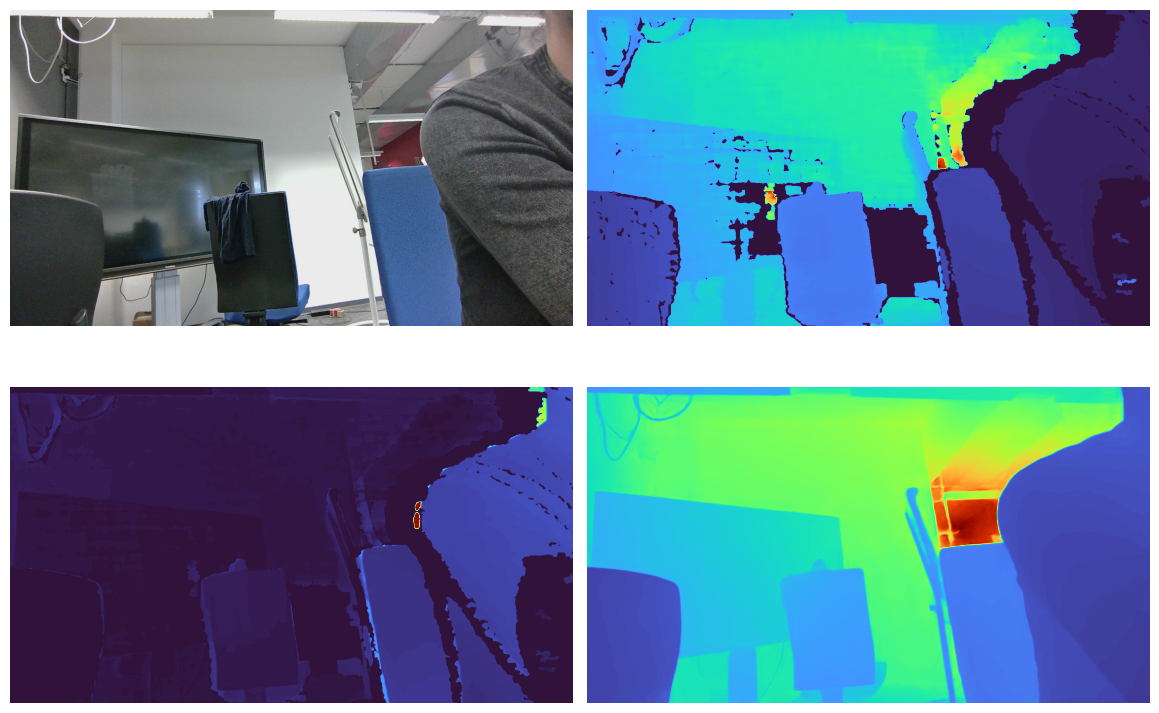

In [ ]:
import ros2_utils.node as utils_node
import rclpy

try:
    rclpy.shutdown()
except:
    pass

utils_node.start_and_spin_node(NodeDepthAnything)